# TESS Archive Tutorial
### By Susan E. Mullally

This is an overview of how to use the astroquery programmatic language to access TESS data at MAST.

This tutorial will cover the following: Querying the TIC, Finding 2-min cadence data from the archive, understanding the difference between target pixel files and light curve files, using TESSCut to work with the FFIs.

See the following presentation for some information on TESS and the archive.
https://docs.google.com/presentation/d/1YImXs_gsx8eOTrM2TLKBL4GaR1Hd5jrTowQwuF975a8/edit?usp=sharing

For more information about the TESS Archive, see https://outerspace.stsci.edu/display/TESS/TESS+Archive+Manual

Most of this tutorial has been borrowed from tutorials by Scott Fleming, Susan Mullally and Clara Brasseur.


**Let's get started**

## Querying the TIC
We will start by using astroquery to query the TESS Input Catalog.  Not all MAST catalogs are available through astroquery.mast.Catalogs

In [1]:
from astroquery.mast import Catalogs
from astroquery.mast import Observations
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

## Astroquery Catalog Cone Search on TIC

We will now use the Catalogs `query_object` function to do a cone search centered on BPM 31594 and return the rows from the TIC catalog.  The function makes use of MAST's name resolver to convert a target name (as a string) into coordinates (Right Ascension and Declination).  Many types of ID's are possible, including any string that can be resolved by Simbad or NED, as well as any target in the Kepler Input Catalog, K2 EPIC Catalog, or the TESS Input Catalog.  The function also can accept a search radius size (specified in degrees), and it needs to know which catalog you want to query.  Catalog options are listed on [this page](https://astroquery.readthedocs.io/en/latest/mast/mast.html#catalog-queries).


In [2]:
target_name = "BPM 31594"  #Pulsating White Dwarf Star
search_radius_deg = 0.1

# Query the TESS Input Catalog centered on HD 209458 with a 0.2 degree radius.
catalogTIC = Catalogs.query_object(target_name, radius=search_radius_deg, catalog="TIC")

# Print out the number of returned rows.
print("Number of TIC objects within %f deg of %s: %u" % (search_radius_deg, target_name, len(catalogTIC)))

Number of TIC objects within 0.100000 deg of BPM 31594: 84


In [3]:
#Print out the columns
catalogTIC.columns

<TableColumns names=('ID','ra','dec','pmRA','pmDEC','Tmag','objType','typeSrc','version','HIP','TYC','UCAC','TWOMASS','SDSS','ALLWISE','GAIA','APASS','KIC','POSflag','e_pmRA','e_pmDEC','PMflag','plx','e_plx','PARflag','gallong','gallat','eclong','eclat','Bmag','e_Bmag','Vmag','e_Vmag','umag','e_umag','gmag','e_gmag','rmag','e_rmag','imag','e_imag','zmag','e_zmag','Jmag','e_Jmag','Hmag','e_Hmag','Kmag','e_Kmag','TWOMflag','prox','w1mag','e_w1mag','w2mag','e_w2mag','w3mag','e_w3mag','w4mag','e_w4mag','GAIAmag','e_GAIAmag','e_Tmag','TESSflag','SPFlag','Teff','e_Teff','logg','e_logg','MH','e_MH','rad','e_rad','mass','e_mass','rho','e_rho','lumclass','lum','e_lum','d','e_d','ebv','e_ebv','numcont','contratio','disposition','duplicate_id','priority','dstArcSec')>

In [4]:
where_closest = np.argmin(catalogTIC['dstArcSec'])

print("Closest TIC ID to %s: TIC %s, separation of %f deg. and a TESS mag. of %f"%
      (target_name, catalogTIC['ID'][where_closest], catalogTIC['dstArcSec'][where_closest],
      catalogTIC['Tmag'][where_closest]))

ticid = catalogTIC['ID'][where_closest]

Closest TIC ID to BPM 31594: TIC 101014997, separation of 0.009714 deg. and a TESS mag. of 15.079000


### Problem.  TIC Query
Determine the ticid of L19-2, a pulsating white dwarf with V magnitude of 13.7.

In [ ]:
target_name = "L19-2"
#Your code here


### Extra Credit. Direct TIC Query
Directly filter the TIC by the integer tic ID to look up the Tess Mag and RA and Dec of that object in the catalog. This is done by using the Catalogs query_criteria and setting the catalog to "TIC".  Take a look at the examples on the [astroquery documentation page](https://astroquery.readthedocs.io/en/latest/mast/mast.html) to see if you can figure out how to filter the TIC by "ID".

In [ ]:
#Your code here


## Finding Lightcurves at MAST

In [5]:
from astropy.io import fits

## Query the MAST CAOM Database

We want to retrieve TESS timeseries data (lightcurve and target pixel files) for the Guest Investigator program G011113 from Sector 1 (PI: JJ Hermes). We will need to query the MAST holdings database for the observations.  First we will simply count the number of observations and then we will request a table of those observations. 

All the filter names are listed on the [MAST CAOM Field Description Page](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html). Or, can be found by hovering over the column names after doing a search in the MAST portal.

The filters we will need to use are, 
- **obs_collection** to specify that we want TESS data
- **dataproduct_type** to specify that we want timeseries data
- **sequence_number** to specify that we want sector 1  
- **propsal_id** to specify the GI program number.  

Hint! More than one GI can propose for the same target so we need wild cards around the name of the program in our query.

In [16]:
#Count the number of observations with query_criteria_count
obsCount = Observations.query_criteria_count(obs_collection = "TESS",
                                             dataproduct_type = ["timeseries"],
                                             sequence_number = 1,
                                             proposal_id = "*G011113*")
print("Number of Observations: %i" % obsCount)

#Print the first 5 with query_criteria
#Notice that the query is the same.
obsTable = Observations.query_criteria(obs_collection = "TESS",
                                       dataproduct_type = ["timeseries"],
                                       sequence_number = 1,
                                       proposal_id = "*G011113*")
obsTable[0:5]['obsid','proposal_id','obs_id']

Number of Observations: 109


obsid,proposal_id,obs_id
str11,str23,str47
17000013114,G011113,tess2018206045859-s0001-0000000161154061-0120-s
17000015482,G011113,tess2018206045859-s0001-0000000183799565-0120-s
17000008092,G011113,tess2018206045859-s0001-0000000092195548-0120-s
17000007384,G011113,tess2018206045859-s0001-0000000302299317-0120-s
17000002987,G011113,tess2018206045859-s0001-0000000325339416-0120-s


### Problem: Query CAOM
Query the same GI program number, but this time try to get all timeseries observed in Sector 1 -- Sector 7. How many observations are there? 

In [ ]:
#Your Code Here


## Retrieve the list of Data Products

Next we use astroquery to retrieve the list of data products that are associated with each observation.  

We will only ask for the data product list associated with the first two in obsTable.  The `[0:10]` can be removed from the code below to get all the observations.

In [11]:
dataProducts = Observations.get_product_list(obsTable[0:3])
dataProducts.colnames

['obsID',
 'obs_collection',
 'dataproduct_type',
 'obs_id',
 'description',
 'type',
 'dataURI',
 'productType',
 'productGroupDescription',
 'productSubGroupDescription',
 'productDocumentationURL',
 'project',
 'prvversion',
 'proposal_id',
 'productFilename',
 'size',
 'parent_obsid']

In [12]:
#Print off the list of observations
dataProducts['obsID', 'productFilename', 'description']

obsID,productFilename,description
str11,str55,str18
17000008092,tess2018206045859-s0001-0000000092195548-0120-s_lc.fits,Light curves
17000008092,tess2018206045859-s0001-0000000092195548-0120-s_tp.fits,Target pixel files
17000013114,tess2018206045859-s0001-0000000161154061-0120-s_lc.fits,Light curves
17000013114,tess2018206045859-s0001-0000000161154061-0120-s_tp.fits,Target pixel files
17000015482,tess2018206045859-s0001-0000000183799565-0120-s_lc.fits,Light curves
17000015482,tess2018206045859-s0001-0000000183799565-0120-s_tp.fits,Target pixel files


## Download Light curves
<a id="download"></a>
We limit our list of data products to just those with the **description** set to "Light curves" because we just want this type of data file. We then download those products. The manifest is an array indicating the download location of the files. 

In [19]:
want = dataProducts['description'] == "Light curves"
lcmanifest = Observations.download_products(dataProducts[want])
print(lcmanifest['Local Path'])

#Get the target pixel files for later.
tpmanifest = Observations.download_products(dataProducts[dataProducts['description'] == "Target pixel files"])

INFO: Found cached file ./mastDownload/TESS/tess2018206045859-s0001-0000000092195548-0120-s/tess2018206045859-s0001-0000000092195548-0120-s_lc.fits with expected size 2039040. [astroquery.query]
INFO: Found cached file ./mastDownload/TESS/tess2018206045859-s0001-0000000161154061-0120-s/tess2018206045859-s0001-0000000161154061-0120-s_lc.fits with expected size 2039040. [astroquery.query]
INFO: Found cached file ./mastDownload/TESS/tess2018206045859-s0001-0000000183799565-0120-s/tess2018206045859-s0001-0000000183799565-0120-s_lc.fits with expected size 2039040. [astroquery.query]
                                                         Local Path                                                        
---------------------------------------------------------------------------------------------------------------------------
./mastDownload/TESS/tess2018206045859-s0001-0000000092195548-0120-s/tess2018206045859-s0001-0000000092195548-0120-s_lc.fits
./mastDownload/TESS/tess2018206045859-s0001

### Problem Download.
Looks like the TESS SPOC pipeline found a TCE (Threshold Crossing Event) when it searched these data for indications of periodic tansits. When a TCE is found, the SPOC pipeline also creates a DV time series FITS file.  Download just the DV time series file for the first observation.

Some of the other fields you might consider filtering on are listed [here](https://outerspace.stsci.edu/display/TESS/7.0+-+Tips+and+Tricks+to+Getting+TESS+Data+At+MAST).

### Bonus Download Problem.
How many of the sector 1 targets produced a TCE (i.e. have a DV time series file)?

### Second Bonus Download Problem
Determine how many missions (hint, MAST calls them obs_collection) have observed your favorite star.  Mine is G185-32. For this one you might want to see the [documentation](https://astroquery.readthedocs.io/en/latest/mast/mast.html) and read about Observations.query_object.

In [ ]:
#Your code here.

#Bonus Problem

#Second Bonus Problem


## Exploring and Plotting the Light Curve File
Let's open a light curve file and look at the different kind of data that is available.  For this let's use the first light curve file we downloaded, tess2018206045859-s0001-0000000140045537-0120-s_lc.fits. And it's associated target pixel file: tess2018206045859-s0001-0000000140045537-0120-s/tess2018206045859-s0001-0000000140045537-0120-s_tp.fits

TESS  only downloads select portions of the sky at a 2-minute cadence. The pixels collected around chosen targets are packaged in a file called the Target Pixel file. Light curve files contain the time series photometry that is derived from those pixels for each target. Each target pixel file packages these pixels as a time series of images in a binary FITS table. These files can then be used to measure the relative photometry of the observed star.  TESS also produces full frame images at a 30-minute cadence. 

For more information about the TESS mission and collected data, visit the [MAST's TESS homepage](http://archive.stsci.edu/tess/). To read more details about TESS Data Products, look in the [TESS Science Product Description Document](https://archive.stsci.edu/missions/tess/doc/EXP-TESS-ARC-ICD-TM-0014.pdf). Once users understand the TESS data, a convenient software package to work with that data is called [lightkurve](https://docs.lightkurve.org/). However, we do not use it below in order to clearly show how the data in the files are organized. 

In [23]:
from astropy.io import fits
from astropy.wcs import WCS

In [24]:
#Use the manifests we created above. It's a 2D array where the file location is in the zeroth element.
lcfile = lcmanifest[2][0]
tpfile = tpmanifest[2][0]
print(tpfile)

./mastDownload/TESS/tess2018206045859-s0001-0000000183799565-0120-s/tess2018206045859-s0001-0000000183799565-0120-s_tp.fits


## Contents of Target Pixel File

Now that we have the file, we can now explore its contents. 
The target pixel file contains 4 extensions: a primary header, a PIXELS extension, an APERTURE extension and a Target Cosmic Ray extension. TPFs can be thought of as stacks of images, with one image for every timestamp the telescope took data. Each timestamp is referred to as a **cadence**. These images are cut out 'postage stamps' of the full observation to make them easier to work with. 

- **No. 0 (Primary):**
<br>This HDU contains meta-data related to the entire file.
- **No. 1 (Pixels):**
<br>This HDU contains a binary table that has 11 columns containing a time series of either scalar values or images. 
- **No. 2 (Aperture):**
<br>This HDU contains an image that gives information about each pixel and how it was used by ther TESS pipeline in the data processing. 
- **No. 3 (Target Cosmic Ray):** 
<br> This HDU is new in the TESS target pixel files and describes the cosmic rays that were identified and subtracted from the target pixels. These cosmic ray corrections are only available if the TESS Pipeline cosmic ray correction algorithm was enabled during processing.

**Contents of the PIXELS extension.**
The pixels extension contains raw and calibrated pixels collected by the spacecraft at a 2-minute cadence. Here is a sumary of the columns available in that extension.

- TIME: Time of mid-cadence stored in BJD-2457000.0.
- CADENCENO: Cadence number
- RAW_CNTS: The raw counts per pixel before any processing.
- FLUX: The calibrated, background subtracted pixels for each cadence.
- FLUX_BKG: The background measured and removed for these pixels. 
- QUALITY: Quality flags.
- POS_CORR1 & POS_CORR2: The (column,row) local motion of the star calculated from the motion polynomials. Motion polynomials are calculated from the PSF centroids of select stars on each CCD. 

In [25]:
#Let's do a couple quick queries to show how to find that information in your files.
fits.info(tpfile)
tphdu = fits.open(tpfile)
tphdu[1].columns

Filename: ./mastDownload/TESS/tess2018206045859-s0001-0000000183799565-0120-s/tess2018206045859-s0001-0000000183799565-0120-s_tp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  PIXELS        1 BinTableHDU    248   20076R x 11C   [D, E, J, 121J, 121E, 121E, 121E, 121E, J, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   
  3  TARGET COSMIC RAY    1 BinTableHDU     27   0R x 4C   [J, I, I, E]   


ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '121J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(11,11)'
    name = 'FLUX'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_ERR'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_BKG'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'FLUX_BKG_ERR'; format = '121E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,11)'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
)

**Show First Calibrated Image.** Note that the RAW_CNTS, FLUX and FLUX_BKG columns contain images. We will use the World Coordinate System information in the APERTURE extension header to overlay the RA and Dec on the image.

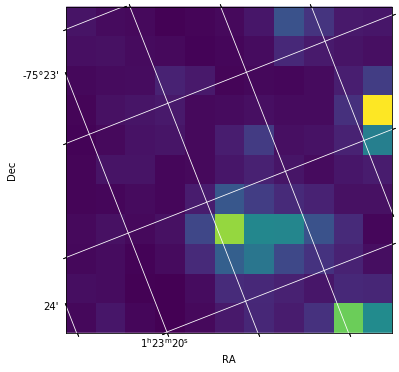

In [28]:
#Plot the first image of the FLUX Column with WCS overlay.
tpf_data = tphdu[1].data
first_image = tpf_data['FLUX'][1]

#The aperture extension header contains the same WCS as that in the Pixels extension.
wcs = WCS(tphdu[2].header)

#Plot the first image in the file.

fig = plt.figure(figsize = (6,6))
fig.add_subplot(111, projection = wcs)

plt.imshow(first_image, origin = 'lower', cmap = plt.cm.viridis)
plt.grid(axis = 'both', color = 'white', ls = 'solid')

plt.xlabel('RA')
plt.ylabel('Dec')

## Contents of the Light Curve File
The light curve file uses the information from the pixels to determine time series photometry. It also contains a host of information regarding the quality of each cadence, the observed motion of the star and how the light curve was extracted.  The extensions available in these data files are as follows. 

- **No. 0 (Primary):**
<br>This HDU contains meta-data related to the entire file.
- **No. 1 (Lightcurve):**
<br>This HDU contains a binary table that has 11 columns containing a time series of either scalar values or images. 
- **No. 2 (Aperture):**
<br>This HDU contains an image that gives information about each pixel and how it was used by ther TESS pipeline in the data processing. This is the same as the target pixel file. 

Recall that we defined lcfile above to point to the file hlsp_tess-data-alerts_tess_phot_00025155310-s01_tess_v1_lc.fits.

**Lighturve Extension.** The lightcurve extension contains most of the data in this type of file. Let's list the columns available in this extension. Unlike the target pixel file, all these data are simply arrays instead of images. Here is a quick run down of the most important inormation in this file. 

- TIME: stored in BJD-2457000
- CADENCENO: Cadence number
- SAP_FLUX: Simple aperture photometry flux. (This is what we calculated above.)
- SAP_BKG: Background flux that has already been removed from SAP_FLUX. 
- PDCSAP_FLUX: Systematics corrected photometry using cotrending basis vectors.
- QUALITY: Quality flags
- PSF_CENTR1 & PSF_CENTR2: The (column,row) position of the star measured using PSF photometry.
- MOM_CENTR1 & MOM_CENTR2: The (column,row) position of the star measured using flux weighted centroids.
- POS_CORR1 & POS_CORR2: The (column,row) local motion of the star calculated from the motion polynomials. Motion polynomials are calculated from the PSF centroids of select stars on each CCD. 

Note, while there is a WCS in the header of these files, it refers to one cadence near the middle of sector. The POS_CORR columns provide information about small changes to that WCS.

In [29]:
#Verify the column names
lchdu = fits.open(lcfile)
fits.info(lcfile)
lchdu[1].columns

Filename: ./mastDownload/TESS/tess2018206045859-s0001-0000000183799565-0120-s/tess2018206045859-s0001-0000000183799565-0120-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   20076R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

### Plot the time series.
Let's pull out the interesting data and take a look.  PDC uses cotrending basis vectors calculated by nearby stars to remove common instrumental trends.


Text(0.5, 0, 'TIME (BTJD)')

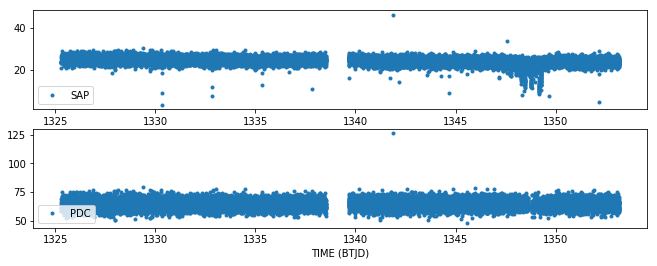

In [30]:
lcdata = lchdu[1].data
sapflux = lcdata['SAP_FLUX']
pdcflux = lcdata['PDCSAP_FLUX']
quality = lcdata['QUALITY']
time = lcdata['TIME']

fig = plt.figure(figsize = (11,4))

fig.add_subplot(211)
plt.plot(time, sapflux,'.', label = 'SAP')
plt.legend(loc = 'lower left')
#plt.ylim(1000,6210)  #Zoom in

fig.add_subplot(212)
plt.plot(time, pdcflux,'.', label = 'PDC')
plt.legend(loc = 'lower left')
plt.xlabel('TIME (BTJD)')
#plt.ylim(50,1500)

**Clean-up both plots by removing cadences flagged as anomalous.** The Quality column contains integers that act as binary flags identified in the TESS data. We are going to remove the data that has been flagged by one of the following flags:

- Bit 1. Attitude Tweak
- Bit 2. Safe Mode
- Bit 3. Coarse Point
- Bit 4. Earth Point
- Bit 5. Argabrightening Event (Sudden brightening across the CCD.)
- Bit 6. Reaction Wheel Desaturation
- Bit 8. Manual Exclude
- Bit 10. Impulsive outlier
- Bit 12. Straylight detected

The other flags are informational and do not necessarily indicate that the cadence should not be used. However, you may have scientifically valid reasons for removing those cadences as well, so it is worth learning about them. See the [archive manual](https://outerspace.stsci.edu/display/TESS/TESS+Archive+Manual) for a full listing of the flags. 

In this case most of the flagged points were allready removed from the PDC light curve, but now the bad points are also removed from the SAP light curve.   This one has some really nice flares!

(1325, 1330)

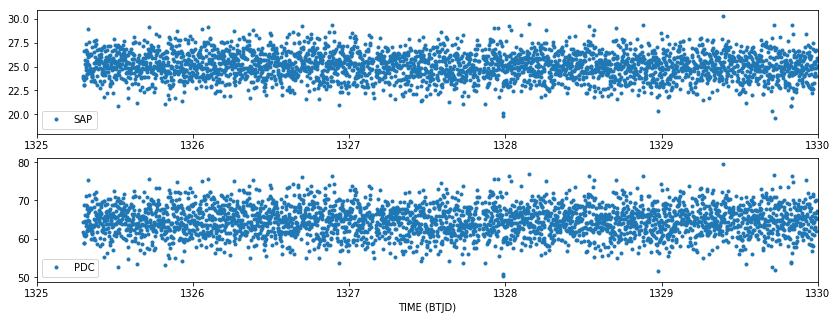

In [31]:
bad_bits = np.array([1,2,3,4,5,6,8,10,12])
value = 0
for v in bad_bits:
    value = value + 2**(v-1)
    
bad_data = np.bitwise_and(quality, value) >= 1 

#Same plot as before with flagged data removed.
fig = plt.figure(figsize = (14,5))
fig.add_subplot(211)
plt.plot(time[~bad_data], sapflux[~bad_data], '.', label = 'SAP')
plt.legend(loc = 'lower left')
plt.xlim(1325,1330)
fig.add_subplot(212)
plt.plot(time[~bad_data], pdcflux[~bad_data], '.', label = 'PDC')
plt.legend(loc = 'lower left')
plt.xlabel('TIME (BTJD)')
plt.xlim(1325,1330)

###   Plot the spacecraft motion.   (Optional)
We will plot the measured (col,row) position of the star as measured from the flux weighted centroids. The spacecraft dumps the momentum gathered in its wheels every once and a while. We can mark when that happens by using the quality flags (bit 6, see above).

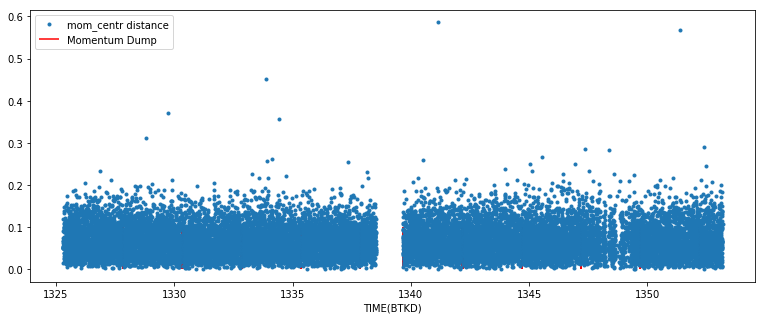

In [32]:
fluxcent_col = lcdata['MOM_CENTR1']
fluxcent_row = lcdata['MOM_CENTR2']
distance = ((fluxcent_col-np.nanmean(fluxcent_col))**2 + (fluxcent_row-np.nanmean(fluxcent_row))**2)**(0.5)

mom_dump = np.bitwise_and(quality, 2**(6-1)) >= 1 

plt.figure(figsize = (13,5))
plt.plot(time[~bad_data], distance[~bad_data], '.', label = "mom_centr distance")
plt.vlines(time[mom_dump], 0,.1, colors = 'r', label = "Momentum Dump")
plt.xlabel('TIME(BTKD)')
plt.legend(loc = "upper left")

### Light curve and target pixel file problem
Using the aperture extension, determine which pixels were used to create the photometric aperture. Change the aperture and create a new light curve for this target. 

**Some useful information.** Each pixel in the aperture extension image is an integer that represents a set of binary flags.  The entire set of flags and what they mean can be found in the TESS Archive Manual.  Of interest to us in this exersize is which pixels belong to the "optimal aperture" used to create this target's light curve. This is the second bit of this set of binary flags. To determine which pixels are in the optimal aperture we need to do a bitwise AND between the pixel value and the value 2. (Similarly, if you wanted to determine which pixels were used to calculate the flux-weighted centroid, you would use the 4th bit which has a value of  2^(4-1)=8.)

In [33]:
#Your Code here
# This one will take more than a couple of lines. So let's do it as a fill in the blank. Look for the !!

#Get the optimal aperture image from the target pixel file.
#!! Fill in the line below.
ap_image = 

#Here we look to see which are said to be in the optimal aperture
ap_want = np.bitwise_and(ap_image, 2) / float(2)  #if the bit is set ap_want will equal 1
plt.imshow(ap_want)


#This function sums up everything in a defined aperture
def aperture_phot(image,aperture):  
    flux = np.sum(image[aperture == 1])
    return flux

#!! You complete this line to pull out the array of images we want from the target pixel file.
tpf_flux = 

#Use the map lambda functions to apply that function to all cadences  (This is a handy trick)
opap_flux = np.array(list (map (lambda x: aperture_phot(x,ap_want), tpf_flux ) ) )

#!! You write the line to get the times from the target pixel file.
time_bjd = 

#Here we plot the time vs flux
plt.figure(figsize = (13,4))
plt.plot(time_bjd, opap_flux,'.', label = 'Optimal Aperture', ms = 6)
plt.legend(loc = "lower left")
plt.xlabel('Time (BJD)', fontsize = 14)
plt.ylabel('Flux (e-/s)', fontsize = 14)

plt.title("TESS Lightcurve Derived from Calibrated Pixels.", fontsize = 14)

SyntaxError: invalid syntax (<ipython-input-33-3c1c4bfb01eb>, line 6)

## Getting the FFI Data
TESS also downloads their entire Full Frame Images on a 30-minute cadence. However if you are working with only a few stars, you probably don't want to have to download the entire set of data.  MAST created a tool called TESSCut to allow you to make cutouts of the TESS FFIs and return something that looks like a target pixel file.

For this example we are going to investigate tic = "00214568914" which shows some weirdness in the 2-min data.

It is left as an exercise to plot that light curve from the light curve files.  But I will produce a fancu plot of the TESS Time series data for you to look like from the DV time series files.

In [ ]:
import requests
from astroquery.mast import Tesscut
from astropy.table import Table
from astropy.coordinates import SkyCoord
import pandas as p

import matplotlib.animation as animation

# For animation display
from matplotlib import rc
from IPython.display import HTML
rc('animation', html='jshtml')

# For bokeh plotting
from bokeh import plotting
plotting.output_notebook()

## Plot the weird event.
Here is some code to pull down the flattened DVT light curve that the TESS project uses to search for planets.  Through exo.MAST we have a database of all the DVT time series, so they can be pulled down without retrieving a FITS files. But a TCE needed to be found on that target.

In [ ]:
exomast_url = "https://exo.mast.stsci.edu/api/v0.1/"
tic_id = "00214568914"
tce = 'TCE_1'

#Make a request for the data for this target.
dv_lightcurve_query = f"{exomast_url}dvdata/tess/{tic_id}/table/?tce={tce}"
response = requests.get(dv_lightcurve_query)
data_dict = response.json()
data = p.DataFrame.from_dict(data_dict['data'])

In [ ]:
detrend = data['LC_DETREND']
model = data['MODEL_INIT']
time = data['TIME']

plt.figure(figsize=(14,4))
plt.plot(time,detrend,'.',lw=0.4)
plt.plot(time,model,'r-',lw=0.6)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Relative Flux')
plt.xlim(1333,1336)
plt.title("Weird event in the light curve of this star.")

### Get the FFI Data for a 50x50 pixel area
First, we need the ra and dec to tell it the location of the FFIs we want. But you already know how to get the RA and Dec for a particular TIC ID using query_criteria.

In [ ]:
#Don't look below, try to remember how query the TIC by ID.
#Your code below.


In [ ]:
#The answer
target=Catalogs.query_criteria(ID=int(tic_id), catalog='Tic')
ra = target['ra']
dec = target['dec']
loc = "%f, %f" % (ra, dec)

### Query how many sectors of data are available
There is only one sector available in this case.

In [ ]:
sectors = Tesscut.get_sectors(loc,radius = 0)
print(sectors)

### Request the time series of images.
You must provide the location and the size of the cutout. See the [documentation](https://astroquery.readthedocs.io/en/latest/mast/mast.html#tesscut) for more features.  It returns a list of open FITS files.

In [ ]:
hdulist = Tesscut.get_cutouts(loc, 20, sector = 1)

In [ ]:
hdulist[0].info()
data = hdulist[0][1].data

### Make an movie of the data.
A Movie can be one of the best ways to understand what is going on.
This movie can take a little while to run, which is why we limit the cadences it is running on.
Another way to do this, which is a bit quicker, but couldn't be done within the notebook is with k2flix by Geert Barentsen.

As you will see, some scatter light (from Mars) goes across the detector creating the strange signal.

In [ ]:
start = np.abs(data['TIME'] - 1332).argmin()
stop = np.abs(data['TIME'] - 1336).argmin()

def make_animation(data_array, start_frame=0, end_frame=None, vmin=None, vmax=None, delay=50):
    """
    Code stolen from Clara Brasseur.
    
    Function that takes an array where each frame is a 2D image array and make an animated plot
    that runs through the frames.
    
    Note: This can take a long time to run if you have a lot of frames.    
    Parameters
    ----------
    data_array : array
        Array of 2D images.
    start_frame : int
        The index of the initial frame to show. Default is the first frame.
    end_frame : int
        The index of the final frame to show. Default is the last frame.
    vmin : float
        Data range min for the colormap. Defaults to data minimum value.
    vmax : float
        Data range max for the colormap. Defaults to data maximum value.
    delay: 
        Delay before the next frame is shown in milliseconds.

    Returns
    -------
    response : `animation.FuncAnimation`
    """
    
    if not vmin:
        vmin = np.min(data_array)
    if not vmax:
        vmax = np.max(data_array)
        
    if not end_frame:
        end_frame = len(data_array) - 1 # set to the end of the array
        
    num_frames = end_frame - start_frame + 1 # include the end frame
        
    def animate(i, fig, ax, binarytab, start=0):
        """Function used to update the animation"""
        ax.set_title("Epoch #" + str(i+start))
        im = ax.imshow(binarytab[i+start], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)
        return im,
    
    # Create initial plot.
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(data_array[start_frame], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)

    ani = animation.FuncAnimation(fig, animate, fargs=(fig, ax, data_array, start_frame), frames=num_frames, 
                                  interval=delay, repeat_delay=1000)
    
    plt.close()
    
    return ani

make_animation(data['FLUX'], start, stop, vmax=500)

### TessCut Problem
Create a light curve from the target pixel file we created.  In this case you have no aperture provided, so you migth just sum up all the pixels. 


In [ ]:
# Your Code Here
tpf_data = hdulist[0][1].data




Tutorial has now ended. The Answers are below.

In [ ]:
#Answers to Astroquery Search.
#Problem 1.
Catalogs.query_object(target_name, radius=search_radius_deg, catalog="TIC")["ID"][0]
#It always returns sorted by distance.  Be careful with high proper motion objects.

#Extra Credit Problem 1.
Catalogs.query_criteria(catalog="Tic",ID=101014997)['Tmag']


In [ ]:
#Problem Query CAOM
obsCount = Observations.query_criteria_count(obs_collection = "TESS",
                                             dataproduct_type = ["timeseries"],
                                             sequence_number = [1,3],
                                             proposal_id = "*G011113*")
print("Number of Observations: %i" % obsCount)

In [ ]:
#Answers to Data Product Query
manifest = Observations.download_products(dataProducts[dataProducts['productSubGroupDescription'] == 'DVT'])

#Bonus Problem
allDataProd = Observations.get_product_list(obsTable)
want = allDataProd['description'] == "Data validation time series"
print("Number of DVT files:  %u" % len(want[want]))

#Second Bonus Problem
obsTable = Observations.query_object("G185-32",radius=".03 deg")
print(np.unique(obsTable['obs_collection']))

In [ ]:
#Answer to the target pixel file problem

ap_image = (tphdu[2].data)
ap_want = np.bitwise_and(ap_image, 2) / float(2)
plt.imshow(ap_want)

#uncomment if you want to Add a pixel to the aperture
#ap_want[4,5]=True
#plt.imshow(ap_want)

#define a simple aperture function to sum-up specified pixels for one cadence
def aperture_phot(image,aperture):  
    flux = np.sum(image[aperture == 1])
    return flux

#Use the map lambda functions to apply that function to all cadences
opap_flux = np.array(list (map (lambda x: aperture_phot(x,ap_want), tpf_data['FLUX'] ) ) )

#extract the time.  
time_bjd = tpf_data["TIME"]

#Plot the time vs flux
plt.figure(figsize = (13,4))
plt.plot(time_bjd, opap_flux,'.', label = 'Optimal Aperture', ms = 6)
plt.legend(loc = "lower left")
plt.xlabel('Time (BJD)', fontsize = 14)
plt.ylabel('Flux (e-/s)', fontsize = 14)

plt.title("TESS Lightcurve Derived from Calibrated Pixels.", fontsize = 14)

In [ ]:
#Answer to Tesscut problem
tpf_data = hdulist[0][1].data

ap_image = (hdulist[0][2].data)
ap_want = ap_image
plt.imshow(ap_want)

#define a simple aperture function to sum-up specified pixels for one cadence
def aperture_phot(image,aperture):  
    flux = np.sum(image[aperture == 1])
    return flux

#Use the map lambda functions to apply that function to all cadences
opap_flux = np.array(list (map (lambda x: aperture_phot(x,ap_want), tpf_data['FLUX'] ) ) )

#extract the time.  
time_bjd = tpf_data["TIME"]

#Plot the time vs flux
plt.figure(figsize = (13,4))
plt.plot(time_bjd, opap_flux,'.', label = 'Optimal Aperture', ms = 6)
plt.legend(loc = "lower left")
plt.xlabel('Time (BJD)', fontsize = 14)
plt.ylabel('Flux (e-/s)', fontsize = 14)

plt.title("TESS Lightcurve Derived from Tess Cut.", fontsize = 14)